#### **ibrahim johar farooqi**
#### **23k-0074**
#### **bai-6a**
#### **dlp - assignment 01**

task 01: adding noise to an image

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

dog = cv2.imread('dog.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32)
shelf = cv2.imread('shelf.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32)
template = cv2.imread('template.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32)

In [2]:
print("shapes:", "dog", dog.shape, "shelf", shelf.shape, "template", template.shape)

shapes: dog (300, 332) shelf (400, 1000) template (56, 39)


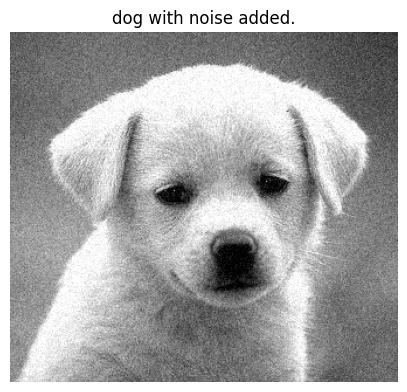

In [6]:
np.random.seed(42)
mean = 0.0
std_dev = 15.0

#generating the noise for the exact shape of the dog img
noise = np.random.normal(loc=mean, scale=std_dev, size=dog.shape).astype(np.float32)

dog_noise = dog + noise

dog_noise = np.clip(dog_noise, 0, 255).astype(np.float32)

cv2.imwrite('dog_noise.png', dog_noise.astype(np.uint8))

plt.figure(figsize=(5,5))
plt.imshow(dog_noise, cmap='gray', vmin=0, vmax=255)
plt.title("dog with noise added.")
plt.axis('off')
plt.show()

task 02: given kernel ([[1,0,-1],[2,0,-2],[1,0,-1]]). apply zero padding, flip the kernel both horizontally and vertically and compute the weighted sum of the neigborhood at each pixel.

In [7]:
kernel = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]], dtype=np.float32)

In [8]:
kernel_flipped = np.flipud(np.fliplr(kernel))

In [9]:
kernel_height, kernel_width = kernel_flipped.shape
pad_height = kernel_height // 2
pad_width = kernel_width // 2

padded = np.pad(dog, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

In [10]:
height, width = dog.shape

final_output = np.zeros((height, width), dtype=np.float32)

In [11]:
for i in range(height):
    for j in range(width):
        #neighborhood region 
        region = padded[i : i + kernel_height, j : j + kernel_width]
        final_output[i, j] = np.sum(region * kernel_flipped)

In [14]:
output_visual = final_output - final_output.min()

if output_visual.max() != 0:
    output_visual = (output_visual * (255.0 / output_visual.max()))
output_visual = np.clip(output_visual, 0, 255).astype(np.uint8)

In [15]:
final_output_abs = np.clip(np.abs(final_output), 0, 255).astype(np.uint8)

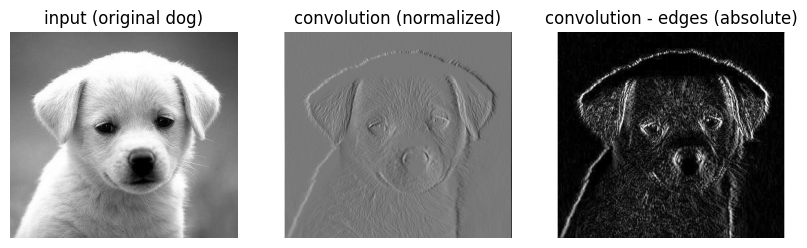

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(dog.astype(np.uint8), cmap='gray')
plt.title('input (original dog)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(output_visual, cmap='gray')
plt.title('convolution (normalized)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(final_output_abs, cmap='gray')
plt.title('convolution - edges (absolute)')
plt.axis('off')
plt.show()

In [23]:
cv2.imwrite('dog_convolution_normalised.png', output_visual)
cv2.imwrite('dog_convolution_edges.png', final_output_abs)

True

task 03

In [24]:
def convolve(image, kernel, flip=True, pad_mode='constant'):
    img = image.astype(np.float32)
    k = kernel.astype(np.float32)
    
    #flip kernel for convolution
    if flip:
        k = np.flipud(np.fliplr(k))
    k_height, k_width = k.shape
    
    pad_height = k_height // 2
    pad_width = k_width // 2
    
    padded = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width)), mode=pad_mode, constant_values=0.0)
    
    height, width = img.shape
    output = np.zeros((height, width), dtype=np.float32)
    
    #explicit region extraction * kernel (weighted sum)
    for i in range(height):
        for j in range(width):
            region = padded[i:i + k_height, j:j + k_width]
            output[i, j] = np.sum(region * k)
            
    return output

In [27]:
def gaussian_kernel(size=7, sigma=1.0):
    ax = np.arange(-(size // 2), (size // 2) + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel.astype(np.float32)
    
    kernel /= kernel.sum()
    
    return kernel

In [28]:
gaus_kernel = gaussian_kernel(size=7, sigma=1.0)
denoised = convolve(dog_noise, gaus_kernel, flip=True)

denoise_clipped = np.clip(denoised, 0, 255).astype(np.uint8)

cv2.imwrite('dog_denoised.png', denoise_clipped)

#for applying sharpening
sharpen_k = np.array([
    [1,4,6,4,1],
    [4,16,24,16,4],
    [6,24,-476,24,6],
    [4,16,24,16,4],
    [1,4,6,4,1]
], dtype=np.float32) * (-1.0 / 256.0)

sharpened = convolve(denoised, sharpen_k, flip=True)

sharpened_clipped = np.clip(sharpened, 0, 255).astype(np.uint8)

cv2.imwrite('dog_sharpened.png', sharpened_clipped)

True

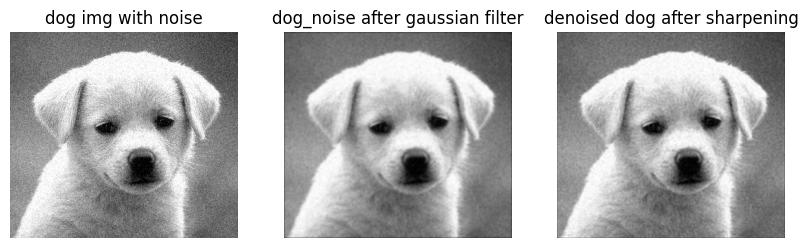

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(dog_noise.astype(np.uint8), cmap='gray')
plt.title('dog img with noise')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(denoise_clipped, cmap='gray')
plt.title('dog_noise after gaussian filter')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(sharpened_clipped, cmap='gray')
plt.title('denoised dog after sharpening')
plt.axis('off')
plt.show()

task 04

In [48]:
shelf = cv2.imread('shelf.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32)
template = cv2.imread('template.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32)

shelf_height, shelf_width = shelf.shape
template_height, template_width = template.shape

shelf_display = cv2.imread('shelf.jpg')

In [49]:
#template matching using convolution

#subtracting mean from both imgs - reduced intensity bias, better matching
shelf_conv = shelf #- np.mean(shelf)
template_conv = template - np.mean(template)

#flip template (v + h) for convolution
template_flipped = np.flipud(np.fliplr(template_conv))
result_conv = np.zeros((shelf_height - template_height + 1, shelf_width - template_width + 1), dtype=np.float32)

for i in range(shelf_height - template_height + 1):
    for j in range(shelf_width - template_width + 1):
        patch = shelf_conv[i:i + template_height, j:j + template_width]
        result_conv[i, j] = np.sum(patch * template_flipped)
        
#find best location
i_conv, j_conv = np.unravel_index(np.argmax(result_conv), result_conv.shape)
print("best match location (convolution):", (i_conv, j_conv))

best match location (convolution): (np.int64(314), np.int64(153))


In [50]:
#template matching using correlation

template_corr = template - np.mean(template)

result_corr = np.zeros((shelf_height - template_height + 1, shelf_width - template_width + 1), dtype=np.float32)

for i in range(shelf_height - template_height + 1):
    for j in range(shelf_width - template_width + 1):
        patch = shelf[i:i + template_height, j:j + template_width]
        
        patch_corr = patch - np.mean(patch)
        result_corr[i, j] = np.sum(patch_corr * template_corr)
        
i_corr, j_corr = np.unravel_index(np.argmax(result_corr), result_corr.shape)

print("best match location (correlation):", (i_corr, j_corr))

best match location (correlation): (np.int64(8), np.int64(41))


In [57]:
shelf_outline = shelf_display.copy()
#convolution match -> red box
shelf_conv_img = shelf_display.copy()
cv2.rectangle(shelf_conv_img, (j_conv, i_conv), (j_conv + template_width, i_conv + template_height), (0, 0, 255), 2)

#correlation match -> green box
shelf_corr_img = shelf_display.copy()
cv2.rectangle(shelf_corr_img, (j_corr, i_corr), (j_corr + template_width, i_corr + template_height),(0, 255, 0), 2)

cv2.imwrite("shelf_matches_conv.png", shelf_conv_img)
cv2.imwrite("shelf_matches_corr.png", shelf_corr_img)

True

In [53]:
def norm_to_uint8(arr):
    a = arr - arr.min()
    if a.max() != 0:
        a = 255.0 * a / a.max()
    return np.clip(a, 0, 255).astype(np.uint8)

cv2.imwrite("conv_response.png", norm_to_uint8(result_conv))
cv2.imwrite("corr_response.png", norm_to_uint8(result_corr))

True

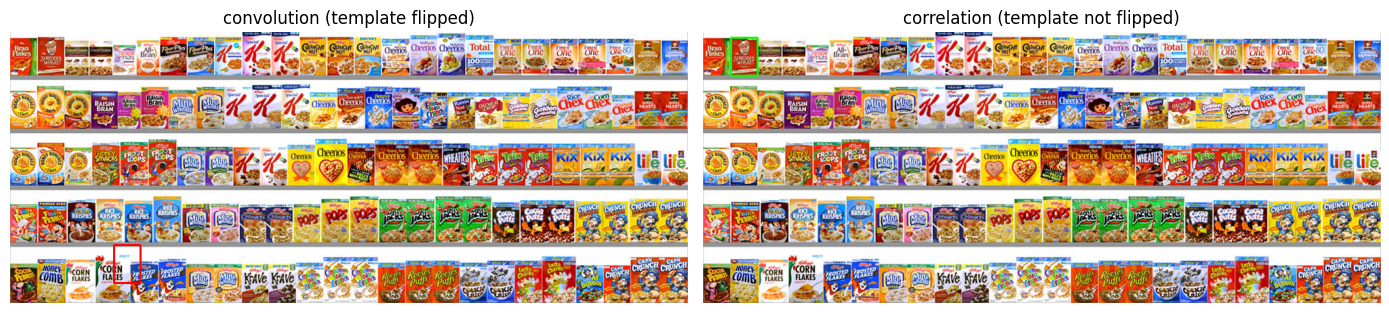

convolution match at (x,y): (153, 314)
correlation match at (x,y): (41, 8)


In [58]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(shelf_conv_img, cv2.COLOR_BGR2RGB))
plt.title("convolution (template flipped)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(shelf_corr_img, cv2.COLOR_BGR2RGB))
plt.title("correlation (template not flipped)")
plt.axis("off")

plt.tight_layout()
plt.show()

print("convolution match at (x,y):", (int(j_conv), int(i_conv)))
print("correlation match at (x,y):", (int(j_corr), int(i_corr)))

**which method more accurately locates the product on the shelf?**

correlation more accurately locates the product. as it preserves the original template orientation while sliding across the image, so it matches the product as it appears on the shelf. on the other hand, convolution flips the template, which can lead to an incorrect match if the template is not symmetric.

**which method is more efficient in terms of computation and implementation?**

both methods have similar computational complexity (O(H × W × h × w)). but correlation is slightly simpler to implement because it doesn't require flipping the template. in real world practice though, optimized library implementations do make both equally efficient.

**why may one method be better suited for template matching in this scenario?**

correlation is better suited because template matching requires preserving the template’s original orientation. since convolution flips the template before the matching happens, it may not correctly locate the product if the orientation matters. hence correlation is more appropriate for detecting objects in natural images.

**using both convolution and correlation, locate the product and analyze which approach is more effective.**

convolution located the product at (153, 314), while correlation located it at (41, 8). the correlation result correctly identified the product on the shelf, while convolution produced a different location due to template flipping. in this case, correlation proved more effective for template matching in this task.